### Setup

In [1]:
%%capture
!sudo apt-get update
!sudo apt install -y tesseract-ocr
!sudo apt install -y tesseract-ocr-heb

In [2]:
%%capture
%pip install pytesseract
%pip install opencv-python-headless

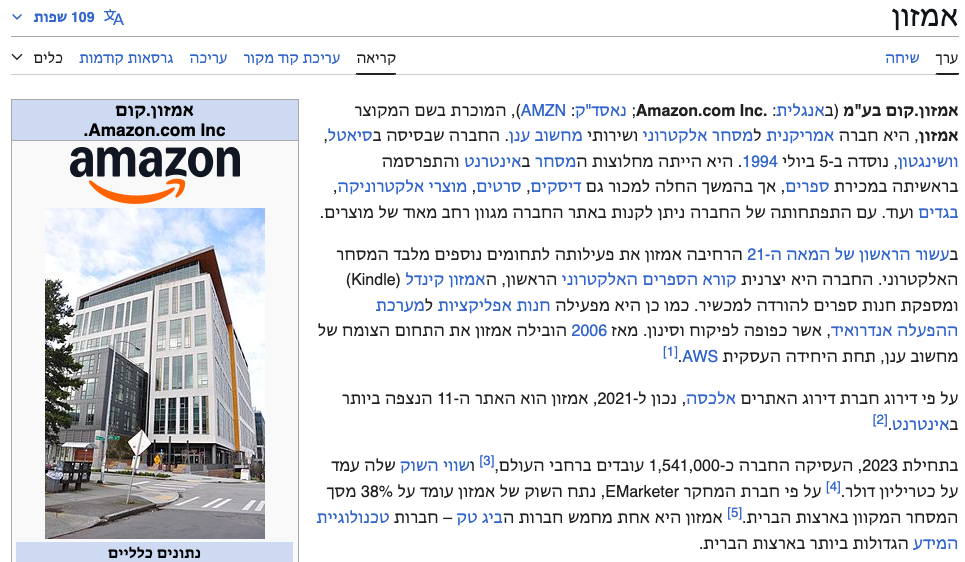

In [27]:
from IPython.display import Image, display

image_file = 'article.png'
display(Image(filename=image_file))

In [28]:
import boto3       
import re

MODEL_ID = 'anthropic.claude-3-5-sonnet-20240620-v1:0'
REGION = 'us-west-2'

bedrock_client = boto3.client('bedrock-runtime', region_name = REGION)


def extract_text_from_tag(xml_string, tag_name):
    pattern = f'<{tag_name}>(.*?)</{tag_name}>'
    match = re.search(pattern, xml_string, re.DOTALL)
    return match.group(1) if match else None
    
def invoke_model(prompt, images_data):
    
    user_message =  {
                "role": "user",
                "content": [
                    {
                        "text": prompt
                    }
                ]
            }
    for image_data in images_data:
        user_message['content'].append({
            'image': {
                'format': 'jpeg',
                'source': {
                    'bytes': image_data
                }
            }
        })

    response = bedrock_client.converse(
        modelId=MODEL_ID,
        messages=[user_message],
        inferenceConfig={
            "maxTokens": 4096,
            "temperature": 0
        },
    )
    response_text = response['output']['message']['content'][0]['text']
    return response_text

class SimplePromptTemplate:
    def __init__(self, template):
        self.template = template

    def format(self, **kwargs):
        return self.template.format(**kwargs)




### Model Only

In [29]:
TEMPLATE = """
Your task is to structure an article from the text in the given image.
You should use the extracted text as is without adding any addtional items or modifying the original text
Use only items which are part of the heading or paragraphs
Think step by steps within the <thinking> tag
Place the result text within the <text> tag.
"""

def extract_text_from_image (image_name):
    image_data = []
    with open(image_name, 'rb') as image_file:
        image_data.append(image_file.read())
    prompt_template = SimplePromptTemplate(template=TEMPLATE)
    prompt = prompt_template.format()
    return invoke_model( prompt, image_data)
model_only_result = extract_text_from_image(image_file)
print (model_only_result)
model_only_result_text = extract_text_from_tag(model_only_result, 'text')

<thinking>
1. The image contains an article about Amazon.com Inc. in Hebrew.
2. I'll structure the article using the main heading and paragraphs.
3. I'll use the exact text from the image without modifications.
4. I'll organize the content in a logical order, starting with the company name and basic information.
5. I'll include the additional information about employee numbers and market share.
</thinking>

<text>
אמזון.קום בע"מ

אמזון.קום בע"מ (באנגלית: Amazon.com Inc.; נאסד"ק: AMZN), המוכרת בשם המקוצר אמזון, היא חברת אמריקנית למסחר אלקטרוני ושירותי מחשוב ענן. החברה שבסיסה בסיאטל, וושינגטון, נוסדה ב-5 ביולי 1994. היא הייתה מחלוצות המסחר באינטרנט והתפתחה בראשיתה כמוכרת ספרים, אך בהמשך החלה למכור גם מוצרים, מוצרי אלקטרוניקה, בגדים ועוד. עם התפתחותה של החברה ניתן לקנות באתר החברה מגוון רחב מאוד של מוצרים.

בעשור הראשון של המאה ה-21 הרחיבה אמזון את פעילותה לתחומים נוספים מלבד המסחר האלקטרוני. החברה היא יצרנית קורא הספרים האלקטרוני הראשון, האמזון קינדל (Kindle) ומספקת תוכנת ספרים להורדה למ

### Hybrid OCR

In [30]:
import cv2 
import pytesseract

def get_image_text_with_ocr(image_file):
    img = cv2.imread(image_file)
    
    # Adding custom options
    custom_config = r'--oem 3 --psm 6'
    return pytesseract.image_to_string(img, config=custom_config, lang='heb')

print(get_image_text_with_ocr(image_file))

אמזון 3 109 שפות ‏
עוך שיחה קריאה עריכת קוד מקור | עריכה ‏ גרסאות קודמות | כלום י
אמזון.קום בע"מ (באנגלית: .סח! החסס.חס2הוחא; נאסד"ק: /4/2), המוכרת בשם המקוצר אמזון.קום
אמזון, היא חברה אמריקנית למסחר אלקטרוני ושירותי מחשוב ענן. החברה שבסיסה בסיאטל, ו
וושינגטון, נוסדה ב-5 ביולי 1994. היא הייתה מחלוצות המסחר באינטרנט והתפרסמה הס2ה וחהּ
בראשיתה במכירת ספרים, אך בהמשך החלה למכור גם דיסקים, סרטים, מוצרי אלקטרוניקה, 2. "₪
בגדים ועוד. עם התפתחותה של החברה ניתן לקנות באתר החברה מגוון רחב מאוד של מוצרים. %
בעשור הראשון של המאה ה-21 הרחיבה אמזון את פעילותה לתחומים נוספים מלבד המסחר 08
האלקטרוני. החברה היא יצרנית קורא הספרים האלקטרוני הראשון, האמזון קינדל (606/9/) ₪ >
ומספקת חנות ספרים להורדה למכשיר. כמו כן היא מפעילה חנות אפליקציות למערכת. | - שו ו -
ההפעלה אנדרואיד, אשר כפופה לפיקוח וסינון. מאז 2006 הובילה אמזון את התחום הצומח של \ ו - (
| | ו
מחשוב ענן, תחת היחידה העסקית פצוא 1'] \ \ 8 - ₪
מו
5 | -
על פי דירוג חברת דירוג האתרים אלכסה, נכון ל-2021, אמזון הוא האתר ה-11 הנצפה ביותר א ו וו / -
באי

In [ ]:
HYBRID_TEMPLATE = """
Your task is to structure an article from text given within the <content> tags.
You should use the input text as is without adding any addtional items or modifying the original text
Use only items which are part of the heading or paragraphs
Use the provided image as reference to the expected artical structure
Think step by steps within the <thinking> tag
Place the result text within the <text> tag.
<content>{content}</content>
"""

def extract_text_from_image_hybrid (image_name):
    images_data = []
    with open(image_name, 'rb') as image_file:
        images_data.append(image_file.read())
    text_from_ocr = get_image_text_with_ocr(image_name)
    prompt_template = SimplePromptTemplate(template=HYBRID_TEMPLATE)
    prompt = prompt_template.format(content = text_from_ocr)
    return invoke_model( prompt, images_data)

hybrid_result = extract_text_from_image_hybrid(image_file)
print (hybrid_result)
hybrid_result_text = extract_text_from_tag(hybrid_result, 'text')

In [ ]:
# Eval
%pip install python-Levenshtein scikit-learn nltk

In [ ]:
def are_strings_equal(str1, str2):
    return str1 == str2

import Levenshtein
def levenshtein_distance(str1, str2):
    return Levenshtein.distance(str1, str2)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_strings(str1, str2):
    vectors = CountVectorizer().fit_transform([str1, str2])
    return cosine_similarity(vectors)[0, 1]


from nltk import word_tokenize
from nltk.util import ngrams

def jaccard_similarity(str1, str2, n=1):
    tokens1 = set(ngrams(word_tokenize(str1), n))
    tokens2 = set(ngrams(word_tokenize(str2), n))
    return len(tokens1 & tokens2) / len(tokens1 | tokens2)


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def tfidf_cosine_similarity(str1, str2):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([str1, str2])
    return cosine_similarity(tfidf_matrix)[0, 1]


In [19]:
groundtruth = """
אמזון.קום בע"מ (באנגלית: .Amazon.com Inc;‏ נאסד"ק: AMZN), המוכרת בשם המקוצר אמזון, היא חברה אמריקנית למסחר אלקטרוני ושירותי מחשוב ענן. החברה שבסיסה בסיאטל, וושינגטון, נוסדה ב-5 ביולי 1994. היא הייתה מחלוצות המסחר באינטרנט והתפרסמה בראשיתה במכירת ספרים, אך בהמשך החלה למכור גם דיסקים, סרטים, מוצרי אלקטרוניקה, בגדים ועוד. עם התפתחותה של החברה ניתן לקנות באתר החברה מגוון רחב מאוד של מוצרים.

בעשור הראשון של המאה ה-21 הרחיבה אמזון את פעילותה לתחומים נוספים מלבד המסחר האלקטרוני. החברה היא יצרנית קורא הספרים האלקטרוני הראשון, האמזון קינדל (Kindle) ומספקת חנות ספרים להורדה למכשיר. כמו כן היא מפעילה חנות אפליקציות למערכת ההפעלה אנדרואיד, אשר כפופה לפיקוח וסינון. מאז 2006 הובילה אמזון את התחום הצומח של מחשוב ענן, תחת היחידה העסקית AWS.[1]

על פי דירוג חברת דירוג האתרים אלכסה, נכון ל-2021, אמזון הוא האתר ה-11 הנצפה ביותר באינטרנט.[2]

בתחילת 2023, העסיקה החברה כ-1,541,000 עובדים ברחבי העולם,[3] ושווי השוק שלה עמד על כטריליון דולר.[4] על פי חברת המחקר EMarketer, נתח השוק של אמזון עומד על 38% מסך המסחר המקוון בארצות הברית.[5] אמזון היא אחת מחמש חברות הביג טק – חברות טכנולוגיית המידע הגדולות ביותר בארצות הברית.
"""

In [ ]:
str1 = groundtruth
str2 = model_only_result_text

print("Levenshtein Distance:", levenshtein_distance(str1, str2))
print("Cosine Similarity:", cosine_similarity_strings(str1, str2))
print("TF-IDF Cosine Similarity:", tfidf_cosine_similarity(str1, str2))

In [ ]:
str1 = groundtruth
str2 = hybrid_result_text

print("Levenshtein Distance:", levenshtein_distance(str1, str2))
print("Cosine Similarity:", cosine_similarity_strings(str1, str2))
print("TF-IDF Cosine Similarity:", tfidf_cosine_similarity(str1, str2))